<a href="https://colab.research.google.com/github/Wallace-NMelo/AM-CIN-UFPE/blob/main/AM_Desafio_06_Wallace_Nascimento_Melo_04_Assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><a href="https://www.nvidia.com/dli"> <img src="https://drive.google.com/uc?id=1J3bpGyJcz-7uOFkUNhvOBiReBCk-sUwR" width="200" </a></center>

# Assessment

In this assessment, you will train a new model that is able to recognize fresh and rotten fruit. You will need to get the model to a validation accuracy of `92%` in order to pass the assessment, though we challenge you to do even better if you can. You will have the use the skills that you learned in the previous exercises. Specifically, we suggest using some combination of transfer learning, data augmentation, and fine tuning. Once you have trained the model to be at least 92% accurate on the validation dataset, save your model, and then assess its accuracy. Let's get started!

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/MyDrive/Colab/Fundamentals_Deep_Learning

!ls

[Errno 2] No such file or directory: '/content/gdrive/MyDrive/Colab/Fundamentals_Deep_Learning'
/content
gdrive	model_plot.png	sample_data


## The Dataset

In this exercise, you will train a model to recognize fresh and rotten fruits. The dataset comes from [Kaggle](https://www.kaggle.com/sriramr/fruits-fresh-and-rotten-for-classification), a great place to go if you're interested in starting a project after this class. The dataset structure is in the `data/fruits` folder. There are 6 categories of fruits: fresh apples, fresh oranges, fresh bananas, rotten apples, rotten oranges, and rotten bananas. This will mean that your model will require an output layer of 6 neurons to do the categorization successfully. You'll also need to compile the model with `categorical_crossentropy`, as we have more than two categories.

<img src="https://drive.google.com/uc?id=1ryuTigL-jyigpICE-veqLZvPz1DCg4ml" style="width: 600px;">

## Load ImageNet Base Model

We encourage you to start with a model pretrained on ImageNet. Load the model with the correct weights, set an input shape, and choose to remove the last layers of the model. Remember that images have three dimensions: a height, and width, and a number of channels. Because these pictures are in color, there will be three channels for red, green, and blue. We've filled in the input shape for you. This cannot be changed or the assessment will fail. If you need a reference for setting up the pretrained model, please take a look at [notebook 05b] where we implemented transfer learning.

Used reference:

[keras: vgg16-function](https://keras.io/api/applications/vgg/#vgg16-function)

In [ ]:
from tensorflow import keras

images_shapes=(224, 224, 3)

pre_trained_weights='imagenet'

base_model = keras.applications.VGG16(
    weights=pre_trained_weights,
    input_shape=images_shapes,
    include_top=False)

## Freeze Base Model

Next, we suggest freezing the base model, as done in [notebook 05b]. This is done so that all the learning from the ImageNet dataset does not get destroyed in the initial training.

In [ ]:
# Freeze base model
base_model.trainable = False

## Add Layers to Model

Now it's time to add layers to the pretrained model. [Notebook 05b] can be used as a guide. Pay close attention to the last dense layer and make sure it has the correct number of neurons to classify the different types of fruit.

In [ ]:
# Create inputs with correct shape
inputs = keras.Input(shape=(224, 224, 3))

x = base_model(inputs, training=False)

# Add pooling layer or flatten layer
x = keras.layers.GlobalAveragePooling2D()(x)

# Add final dense layer
n_layers = 6
outputs = keras.layers.Dense(n_layers, activation = 'softmax')(x)

# Combine inputs and outputs to create model
model = keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 6)                 3078      
                                                                 
Total params: 14717766 (56.14 MB)
Trainable params: 3078 (12.02 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


# Visualization of model

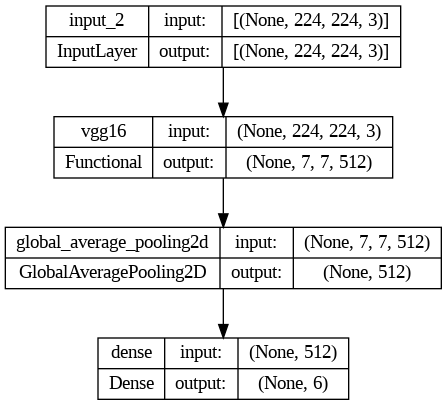

In [ ]:
from keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## Compile Model

Now it's time to compile the model with loss and metrics options. Remember that we're training on a number of different categories, rather than a binary classification problem.

In [ ]:
model.compile(loss = 'categorical_crossentropy' , metrics = ['accuracy'])

## Augment the Data

If you'd like, try to augment the data to improve the dataset. Feel free to look at [notebook 04a] and [notebook 05b] for augmentation examples. There is also documentation for the [Keras ImageDataGenerator class](https://keras.io/api/preprocessing/image/#imagedatagenerator-class). This step is optional, but it may be helpful to get to 92% accuracy.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create a data generator
datagen_train = ImageDataGenerator(
    samplewise_center=True,  # set each sample mean to 0
    rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range=0.1,  # Randomly zoom image
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False,
)

# No need to augment validation data
datagen_valid = ImageDataGenerator(samplewise_center=True)

## Load Dataset

Now it's time to load the train and validation datasets. Pick the right folders, as well as the right `target_size` of the images (it needs to match the height and width input of the model you've created). For a reference, check out [notebook 05b].

In [ ]:
# load and iterate training dataset
train_it = datagen_train.flow_from_directory(
    '/content/gdrive/MyDrive/data/fruits/train/',
    target_size=(224,224),
    color_mode="rgb",
    class_mode="categorical",
)
# load and iterate validation dataset
valid_it = datagen_valid.flow_from_directory(
    '/content/gdrive/MyDrive/data/fruits/valid/',
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
)

Found 1182 images belonging to 6 classes.
Found 329 images belonging to 6 classes.


## Train the Model

Time to train the model! Pass the `train` and `valid` iterators into the `fit` function, as well as setting the desired number of epochs.

In [ ]:
history_model = model.fit(train_it,
          validation_data=valid_it,
          steps_per_epoch=train_it.samples/train_it.batch_size,
          validation_steps=valid_it.samples/valid_it.batch_size,
          epochs=5, verbose=1)

Epoch 1/5
36/36 [==============================] - 33s 884ms/step - loss: 0.1061 - accuracy: 0.9636 - val_loss: 0.1961 - val_accuracy: 0.9544
Epoch 2/5
36/36 [==============================] - 30s 821ms/step - loss: 0.0845 - accuracy: 0.9679 - val_loss: 0.2289 - val_accuracy: 0.9453
Epoch 3/5
36/36 [==============================] - 28s 775ms/step - loss: 0.0693 - accuracy: 0.9755 - val_loss: 0.1866 - val_accuracy: 0.9635
Epoch 4/5
36/36 [==============================] - 28s 744ms/step - loss: 0.0671 - accuracy: 0.9848 - val_loss: 0.1893 - val_accuracy: 0.9544
Epoch 5/5
36/36 [==============================] - 33s 886ms/step - loss: 0.0434 - accuracy: 0.9890 - val_loss: 0.1831 - val_accuracy: 0.9605


In [ ]:
history_model.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

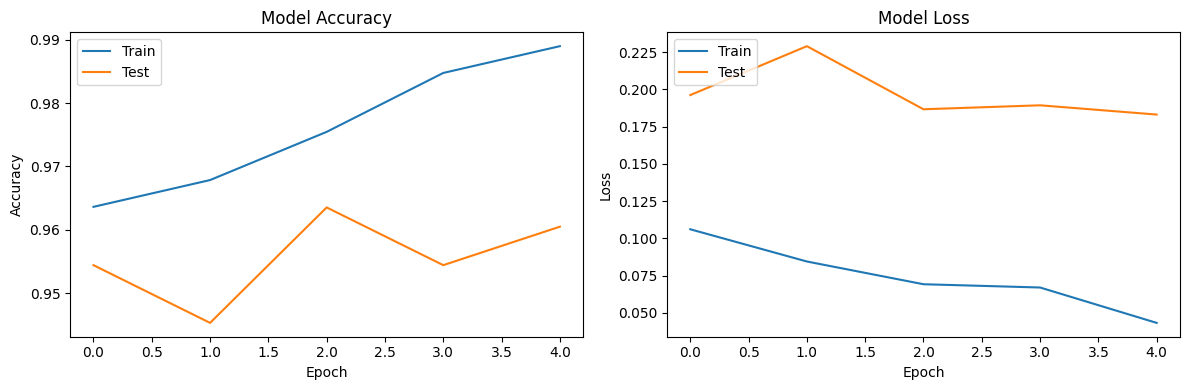

In [ ]:
import matplotlib.pyplot as plt

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot accuracy in the first subplot
ax1.plot(history_model.history['accuracy'])
ax1.plot(history_model.history['val_accuracy'])
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Test'], loc='upper left')

# Plot loss in the second subplot
ax2.plot(history_model.history['loss'])
ax2.plot(history_model.history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Test'], loc='upper left')

# Adjust layout to prevent clipping of labels
plt.tight_layout()

# Show the plots
plt.show()


## Unfreeze Model for Fine Tuning

If you have reached 92% validation accuracy already, this next step is optional. If not, we suggest fine tuning the model with a very low learning rate.

In [ ]:
# Unfreeze the base model
base_model.trainable = True

# Compile the model with a low learning rate
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate = 0.00001),
              loss = 'categorical_crossentropy' , metrics = ['accuracy'])

In [ ]:
history_model2 = model.fit(train_it,
          validation_data=valid_it,
          steps_per_epoch=train_it.samples/train_it.batch_size,
          validation_steps=valid_it.samples/valid_it.batch_size,
          epochs=5, verbose=1)

Epoch 1/5
36/36 [==============================] - 48s 1s/step - loss: 0.0930 - accuracy: 0.9695 - val_loss: 0.2344 - val_accuracy: 0.9422
Epoch 2/5
36/36 [==============================] - 33s 897ms/step - loss: 0.0514 - accuracy: 0.9814 - val_loss: 0.1273 - val_accuracy: 0.9666
Epoch 3/5
36/36 [==============================] - 33s 884ms/step - loss: 0.0170 - accuracy: 0.9941 - val_loss: 0.1578 - val_accuracy: 0.9635
Epoch 4/5
36/36 [==============================] - 34s 917ms/step - loss: 0.0039 - accuracy: 0.9992 - val_loss: 0.1929 - val_accuracy: 0.9574
Epoch 5/5
36/36 [==============================] - 34s 905ms/step - loss: 0.0172 - accuracy: 0.9949 - val_loss: 0.1305 - val_accuracy: 0.9757


In [ ]:
history_model2.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

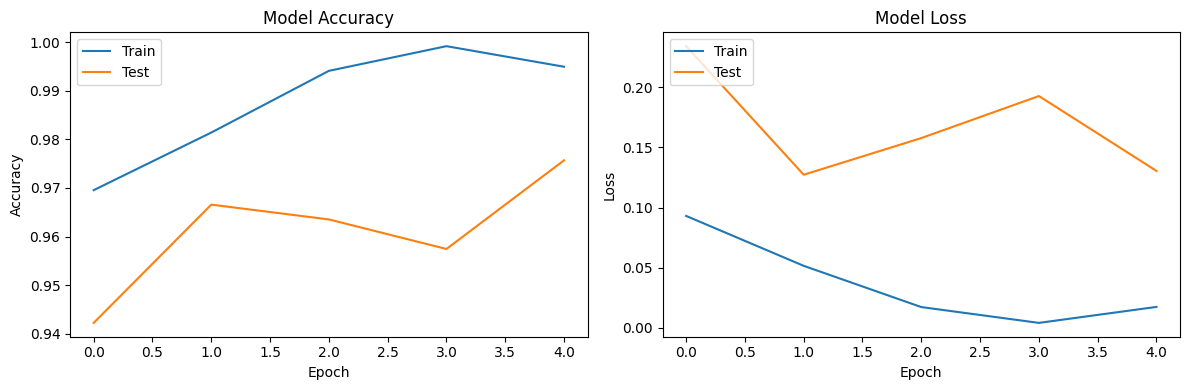

In [ ]:
import matplotlib.pyplot as plt

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot accuracy in the first subplot
ax1.plot(history_model2.history['accuracy'])
ax1.plot(history_model2.history['val_accuracy'])
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Test'], loc='upper left')

# Plot loss in the second subplot
ax2.plot(history_model2.history['loss'])
ax2.plot(history_model2.history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Test'], loc='upper left')

# Adjust layout to prevent clipping of labels
plt.tight_layout()

# Show the plots
plt.show()

## Evaluate the Model

Hopefully, you now have a model that has a validation accuracy of 92% or higher. If not, you may want to go back and either run more epochs of training, or adjust your data augmentation.

Once you are satisfied with the validation accuracy, evaluate the model by executing the following cell. The evaluate function will return a tuple, where the first value is your loss, and the second value is your accuracy. To pass, the model will need have an accuracy value of `92% or higher`.

In [ ]:
model.evaluate(valid_it, steps=valid_it.samples/valid_it.batch_size)

10/10 [==============================] - 3s 292ms/step - loss: 0.1305 - accuracy: 0.9757


[0.13048304617404938, 0.975683867931366]